# Bridging Neural Dynamics: extending TRFs - Part 2 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Hugo-W/CNSP25_tutorial_HWeissbart/main/)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Hugo-W/CNSP25_tutorial_HWeissbart/blob/main/notebooks/part_2.ipynb)


This time let's load some real MEG data and try our freshly designed feature-based Phase-Amplitude Coupling extraction. If time allows, will move onto trying to disentangle brain response to acoustic edges around uncertain vs more certain words, to see whether top-down linguistic information affects lower level envelope tracking.

### Setup (Google Colab only)

> We need an extra step to make sure widgets can work in Collab notebooks, uncomment and run the cell bellow if using Google Collab, otherwise just skip this.

In [ ]:
try:
  import google.colab # type: ignore
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %pip install -q ipywidgets ipympl
    %pip install -q natmeeg mne
    print("🔁 Restarting kernel to use newly installed packages... Just wait that the kernel restarts, then start by running the cell below.")
    get_ipython().kernel.do_shutdown(True) # type: ignore

In [ ]:
try:
  import google.colab # type: ignore
  IN_COLAB = True
except:
  IN_COLAB = False
  
# Download `utils`
if IN_COLAB:
    import requests
    import os

    files = ['__init__.py', 'helpers.py', 'surrogate.py', 'visu.py', 'utils.py']
    # Create utils directory if it doesn't exist
    os.makedirs('utils', exist_ok=True)
    for f in files:
        url = f'https://raw.githubusercontent.com/Hugo-W/CNSP25_tutorial_HWeissbart/main/utils/{f}'
        response = requests.get(url)

        with open(f'utils/{f}', 'wb') as f:
            f.write(response.content)

    from google.colab import output # type: ignore
    output.enable_custom_widget_manager()

## Imports and Data download

First let's get all the libraries, data and path setup.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import sys, os

import mne

# Add utils to Python path
sys.path.append('..') # access to utils.py and visu.py modules
from utils.utils import download_file, list_h5_data, normalize_complex

The cell below will download the data if they are not already present in the `data/` folder.

In [ ]:
data_dir = "../data/"
files = {
    "sub-001/audioBook-filtered-ICAed-raw.fif": "https://osf.io/download/689ca8ab66c0f8121bd5a0fd/",
    "sub-001/audioBook-eve.fif": "https://osf.io/download/d7phu/",
    "sub-001/noise-cov.fif": "https://osf.io/download/689ca6fa89cdf5804c13c704/",
    "stim/predictors.hdf5": "https://osf.io/download/68b3114c95a919eba5fe1c79/"
}
# Bad channels: MLF12, MRC55, MRF61

for file_name, url in files.items():
    file_path = os.path.join(data_dir, file_name)
    # Check if the data directory exists, if not create it
    if not os.path.exists(os.path.join(data_dir, os.path.dirname(file_name))):
        os.makedirs(os.path.join(data_dir, os.path.dirname(file_name)))

    # Check if the file already exists
    if not os.path.exists(file_path):
        print(f"{file_name} not found. Downloading...")
        download_file(url, file_path)
    else:
        print(f" ✅ File {file_name} already exists in the {data_dir} directory.")

 ✅ File audioBook-filtered-ICAed-raw.fif already exists in the ../data/sub-001 directory.
 ✅ File audioBook-eve.fif already exists in the ../data/sub-001 directory.
 ✅ File noise-cov.fif already exists in the ../data/sub-001 directory.


Let's have a look into the HDF5 file of stimulus features:

In [ ]:
list_h5_data("../data/stim/predictors.hdf5", max_depth=4)

transcripts_v2
├── 100
│   ├── acoustic
│   │   ├── ANGE_part1_normalized (27402,)
│   │   ├── Anderson_S01_P01_normalized (29800,)
│   │   ├── Anderson_S01_P02_normalized (31770,)
│   │   ├── Anderson_S01_P03_normalized (28900,)
│   │   ├── Anderson_S01_P04_normalized (35080,)
│   │   ├── BALL_part1_normalized (29801,)
│   │   ├── EAUV_part1_normalized (34382,)
│   │   ├── EAUV_part2_normalized (36153,)
│   │   ├── grimm_20_1_normalized (36659,)
│   │   ├── grimm_20_2_normalized (40055,)
│   │   ├── grimm_23_1_normalized (30309,)
│   │   ├── grimm_23_2_normalized (33287,)
│   │   ├── grimm_23_3_normalized (30292,)
│   ├── wordlevel
│   │   ├── ANGE_part1_normalized (27402, 9)
│   │   ├── Anderson_S01_P01_normalized (29800, 9)
│   │   ├── Anderson_S01_P02_normalized (31770, 9)
│   │   ├── Anderson_S01_P03_normalized (28900, 9)
│   │   ├── Anderson_S01_P04_normalized (35080, 9)
│   │   ├── BALL_part1_normalized (29801, 9)
│   │   ├── EAUV_part1_normalized (34382, 9)
│   │   ├── EAUV_par

We can see that the stimulus feature file `predictors.hdf5` contains a matrix of feature per story, organised under two keys: `acoustic` and `wordlevel`. The former contains the smooth continuous feature (only envelop here), while the latter contains impulse-like time series of word-level features. 

We can also observe that word level features are matrices with 9 columns. These map to the following features (in that order):

- Always on feature
    - word onset
- Valued features
    - surprisal
    - entorpy
    - KL divergence
    - prediction error (= surprisal weighted by precision ~1/entropy)
    - word frequency
    - depth in constituency tree
    - number of closing branches for current word
    - number of opening branches for current word

## Read in stimulus features

In [2]:
from utils.utils import get_feature_signal, STORY_IDs

In [3]:
events = mne.read_events('../data/sub-001/audioBook-eve.fif')

In [4]:
X = get_feature_signal()

Load stimulus features
Loading feature signal for : ['acoustic', 'wordonsets']
Done. X shape: (29800, 2)


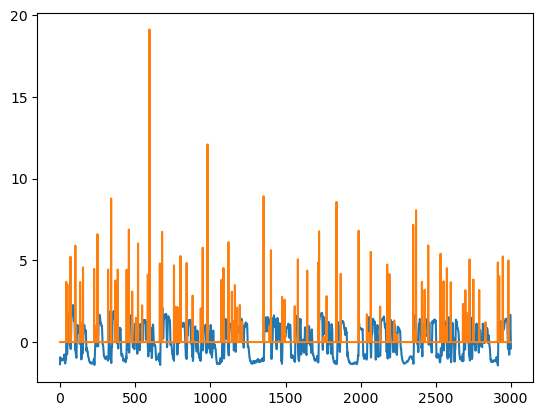

In [5]:
plt.plot(X[0][:100*30])

In [6]:
STORY_IDs

{11: 'Anderson_S01_P01_normalized',
 12: 'Anderson_S01_P02_normalized',
 13: 'Anderson_S01_P03_normalized',
 14: 'Anderson_S01_P04_normalized',
 21: 'grimm_23_1_normalized',
 22: 'grimm_23_2_normalized',
 23: 'grimm_23_3_normalized',
 31: 'grimm_20_1_normalized',
 32: 'grimm_20_2_normalized',
 41: 'EAUV_part1_normalized',
 42: 'EAUV_part2_normalized',
 51: 'ANGE_part1_normalized',
 61: 'BALL_part1_normalized'}

In [20]:
def get_story_sample_onsets(events, fs=200, sample=False):
    " if sample is True give the exact sample index, otherwise gives time."
    id_story = {v:k for k,v in STORY_IDs.items()}
    onsets = {}
    for s in id_story:
        id_ = 100 + id_story[s]
        if id_ not in events[:, 2]:
            print(f"{id_} not in events, skipping")
            continue
        onsets[s] = events[np.where(events[:, 2] == id_)[0][0]][0]
        if not sample:
            onsets[s] /= fs
    return onsets

In [21]:
get_story_sample_onsets(events)

142 not in events, skipping
151 not in events, skipping
161 not in events, skipping


{'Anderson_S01_P01_normalized': np.float64(3748.14),
 'Anderson_S01_P02_normalized': np.float64(15.545),
 'Anderson_S01_P03_normalized': np.float64(2004.925),
 'Anderson_S01_P04_normalized': np.float64(2905.485),
 'grimm_23_1_normalized': np.float64(4112.39),
 'grimm_23_2_normalized': np.float64(428.895),
 'grimm_23_3_normalized': np.float64(2439.71),
 'grimm_20_1_normalized': np.float64(4505.275),
 'grimm_20_2_normalized': np.float64(865.31),
 'EAUV_part1_normalized': np.float64(4861.98)}

## Read MEG data

In [ ]:
import mne
import numpy as np

In [ ]:
raw = mne.io.read_raw('../data/sub-001/audioBook-filtered-ICAed-raw.fif', preload=True)
raw = raw.pick_types(meg=True, ref_meg=False)
print(raw._data.shape)

Opening raw data file ../data/sub-001/audioBook-filtered-ICAed-raw.fif...
    Read 5 compensation matrices
    Range : 89737 ... 1132892 =    448.685 ...  5664.460 secs
Ready.
Current compensation grade : 0
Reading 0 ... 1043155  =      0.000 ...  5215.775 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.
(269, 1043156)


In [ ]:
def normalize_complex(sig):
    return sig/np.abs(sig)

In [ ]:
# Low band
fphase_low, fphase_high = 4, 7
# High band
famp_low, famp_high = 30, 49
# Process data
raw = raw.resample(100)
phase_data = raw.copy().filter(l_freq=fphase_low, h_freq=fphase_high).apply_hilbert(envelope=False)
amp_data = raw.copy().filter(l_freq=famp_low, h_freq=famp_high).apply_hilbert(envelope=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.6s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 331 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.3s


NameError: name 'np' is not defined

In [ ]:
phase_data = phase_data.apply_function(normalize_complex)
# phase_data = mne.filter.filter_data(data=raw._data, sfreq=raw.info['sfreq'], l_freq=fphase_low, h_freq=fphase_high)
# amp_data = mne.filter.filter_data(data=raw._data, sfreq=raw.info['sfreq'], l_freq=famp_low, h_freq=famp_high)

In [ ]:
analytical = phase_data.copy()
analytical._data *= amp_data._data

In [ ]:
del raw, amp_data, phase_data